time for plotting cells on mean image for recording : 6.560720920562744
time for plotting cells on mean image for recording : 6.438910961151123
time for plotting cells on mean image for recording : 6.420838832855225
time for plotting cells on mean image for recording : 6.291527271270752
time for plotting cells on mean image for recording : 6.412191867828369


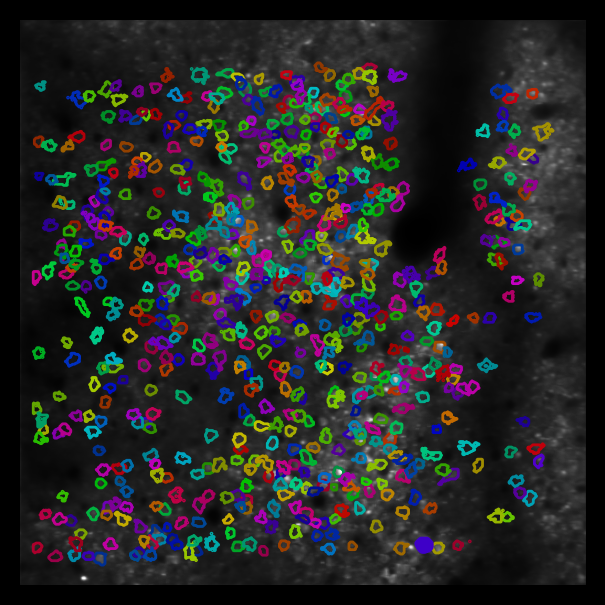

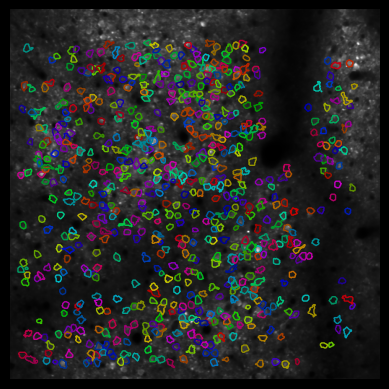

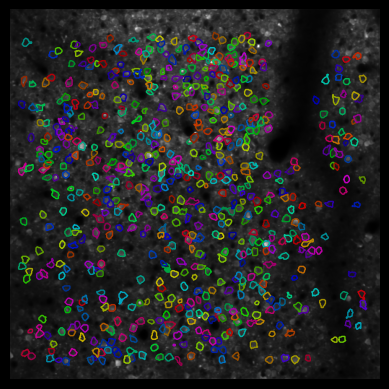

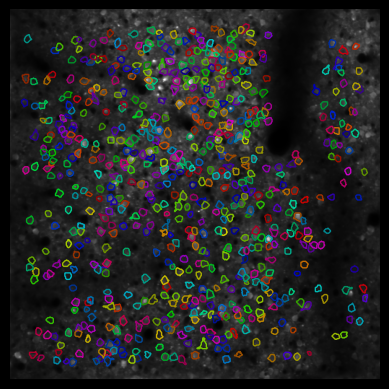

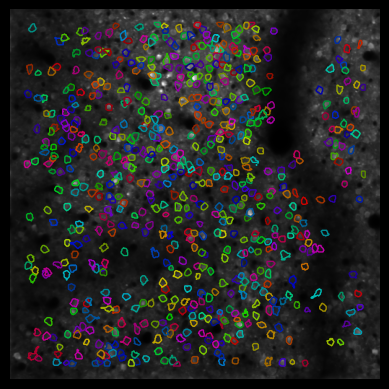

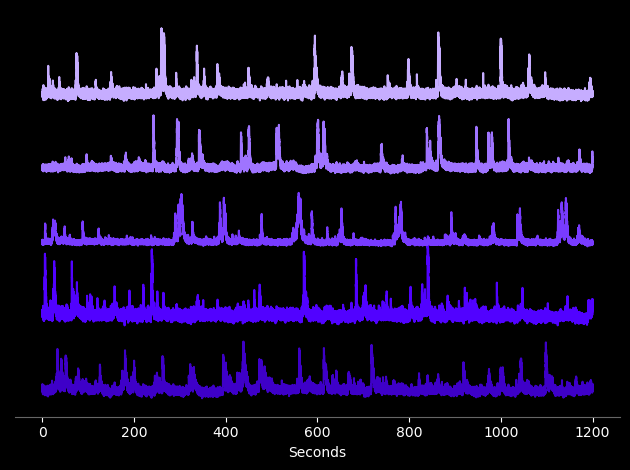

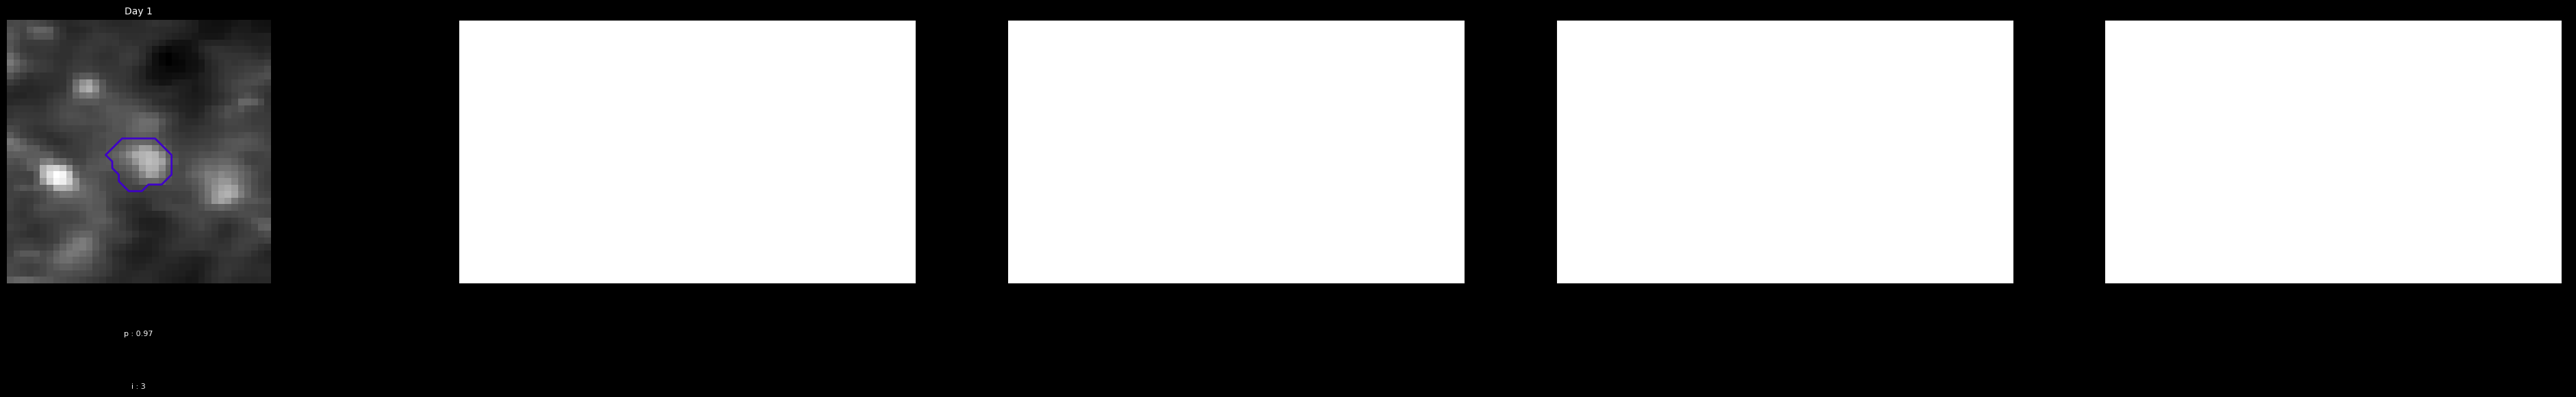

Application took 43.71820592880249 seconds to open.
Cellule sélectionnée : 4
time taken for updating: 1.724499225616455
Cellule sélectionnée : 375
time taken for updating: 1.3378119468688965
Cellule sélectionnée : 434
time taken for updating: 1.5396218299865723


Traceback (most recent call last):
  File "/opt/anaconda3/envs/track2p/lib/python3.9/site-packages/matplotlib/cbook/__init__.py", line 287, in process
    func(*args, **kwargs)
  File "/var/folders/j2/0_34_fp15fsbkqbjs6hkp84h0000gn/T/ipykernel_42572/369733694.py", line 199, in on_release
    self.rect.set_width(self.x1 - self.x0)
TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'


In [1]:
import colorsys
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.backends.backend_qt5agg import NavigationToolbar2QT as NavigationToolbar
from PyQt5.QtCore import Qt
import os
import numpy as np
from qtpy.QtCore import Signal
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
import matplotlib.pyplot as plt
from scipy.stats import zscore
from PyQt5.QtWidgets import QApplication, QTabWidget, QVBoxLayout, QWidget, QSplitter, QHBoxLayout, QFrame, QFrame
from PyQt5.QtCore import Qt
import skimage
import matplotlib.colors as mcolors
import random
import time 
import matplotlib.patches as patches


'''FigureCanvas is a matplotlib class to manage figures and drawings'''

class ZoomPlotWidget(FigureCanvas):
    """It is used to display the roi of the selected cell across days with each zoom being a different day. 
    The roi is centered on the median coordinates of the selected cell. The mean image of the recording is used to create the zooms. 
    The probability of the cell being a cell and the index of the cell in the suite2p files associated with each recording (day) are also displayed under the zooms."""
    
    def __init__(self,  all_ops=None, all_stat_t2p=None, colors=None, all_is_cell=None,t2p_match_mat_allday =None):
        nb_plot=len(all_is_cell)
        self.fig, self.ax_zoom = plt.subplots(1, nb_plot, figsize = (10*nb_plot, nb_plot), gridspec_kw={'width_ratios': [1] * nb_plot},facecolor='black')
        super().__init__(self.fig)
        self.all_ops = all_ops
        self.all_stat_t2p = all_stat_t2p
        self.colors = colors
        self.all_is_cell=all_is_cell
        self.t2p_match_mat_allday =t2p_match_mat_allday 

    def display_zooms(self, selected_cell_index):
        """It is called when the application is opened and a cell is selected."""
        roi_dict={} #it is used to store the roi and the median coordinates of the selected cell for each recording (day)
        if self.all_ops is not None and self.all_stat_t2p is not None and self.all_is_cell is not None:
            for i in range(len(self.all_ops)):
                wind = 20
                mean_img = self.all_ops[i]['meanImg']
                stat_t2p = self.all_stat_t2p[i]
                median_coord = stat_t2p[selected_cell_index]['med']
                #if the median coordinates of the selected cell are close to the edges of the mean image, the roi is cropped to avoid an index out of range error
                if (int(median_coord[0]) + wind) > mean_img.shape[0] and (median_coord[1] + wind) > mean_img.shape[1]:   
                    out_x = (int(median_coord[0]) + wind) - mean_img.shape[0]
                    out_y = (int(median_coord[1]) + wind) - mean_img.shape[1]
                    new_coordinate_x = int(median_coord[0]) - out_x
                    new_coordinate_y = int(median_coord[1]) - out_y
                    roi = mean_img[new_coordinate_x-wind:new_coordinate_x+wind, new_coordinate_y-wind:new_coordinate_y+wind]
                    median_coord[1]= new_coordinate_y
                    median_coord[0]=new_coordinate_x
                    roi_dict[i] = (roi, median_coord)
                elif (int(median_coord[0]) + wind) > mean_img.shape[0]: 
                    out_x = (int(median_coord[0]) + wind) - mean_img.shape[0]
                    new_coordinate_x = int(median_coord[0]) - out_x
                    roi = mean_img[new_coordinate_x-wind:new_coordinate_x+wind, int(median_coord[1])-wind:int(median_coord[1])+wind]
                    median_coord[0]=new_coordinate_x
                    roi_dict[i] = (roi, median_coord)
                elif (int(median_coord[1]) + wind) > mean_img.shape[1]: 
                    out_y = (int(median_coord[1]) + wind) - mean_img.shape[1]
                    new_coordinate_y = int(median_coord[1]) - out_y
                    roi = mean_img[int(median_coord[0])-wind:int(median_coord[0])+wind, new_coordinate_y-wind:new_coordinate_y+wind]
                    median_coord[1]= new_coordinate_y
                    roi_dict[i] = (roi, median_coord)
                elif (int(median_coord[0]) + wind)  > mean_img.shape[0] and (median_coord[1] - wind) <0:   
                    out_x = (int(median_coord[0]) + wind) - mean_img.shape[0]
                    out_y= 0 - (int(median_coord[1]) - wind) 
                    new_coordinate_x= int (median_coord[0]) - out_x
                    new_coordinate_y= int (median_coord[1]) + out_y
                    roi = mean_img[new_coordinate_x-wind:new_coordinate_x+wind, new_coordinate_y-wind:new_coordinate_y+wind]
                    median_coord[1]= new_coordinate_y
                    median_coord[0]=new_coordinate_x
                    roi_dict[i] = (roi, median_coord)
                elif (median_coord[1] - wind) <0:   
                    out_y= 0 - (int(median_coord[1]) - wind) 
                    new_coordinate_y= int (median_coord[1]) + out_y
                    roi= mean_img[int(median_coord[0])-wind:int(median_coord[0])+wind, new_coordinate_y-wind:new_coordinate_y+wind]
                    median_coord[1]= new_coordinate_y
                    roi_dict[i] = (roi, median_coord)
                elif (int(median_coord[0]) - wind) <0:
                    out_x = 0 - (int(median_coord[0]) - wind)
                    new_coordinate_x= int (median_coord[0]) + out_x
                    roi= mean_img[new_coordinate_x-wind:new_coordinate_x+wind, int(median_coord[1])-wind:int(median_coord[1])+wind]
                    median_coord[0]=new_coordinate_x
                    roi_dict[i] = (roi, median_coord)
                elif (int(median_coord[0]) - wind) <0 and (median_coord[1] + wind) > mean_img.shape[1]:   
                    out_x = 0 - (int(median_coord[0]) - wind)
                    out_y= (int(median_coord[1]) + wind) - mean_img.shape[1]
                    new_coordinate_x= int (median_coord[0]) + out_x
                    new_coordinate_y= int (median_coord[1]) - out_y
                    roi = mean_img[new_coordinate_x-wind:new_coordinate_x+wind, new_coordinate_y-wind:new_coordinate_y+wind]
                    median_coord[0]=new_coordinate_x
                    median_coord[1]= new_coordinate_y
                    roi_dict[i] = (roi, median_coord)
                elif (int(median_coord[0]) - wind) <0  and (median_coord[1] - wind) <0: 
                    out_x = 0 - (int(median_coord[0]) - wind)
                    out_y= 0 - (int(median_coord[1]) - wind) 
                    new_coordinate_x= int (median_coord[0]) + out_x
                    new_coordinate_y= int (median_coord[1]) + out_y
                    roi = mean_img[new_coordinate_x-wind:new_coordinate_x+wind, new_coordinate_y-wind:new_coordinate_y+wind] 
                    median_coord[0]=new_coordinate_x
                    median_coord[1]= new_coordinate_y
                    roi_dict[i] = (roi, median_coord)
                else: 
                    roi = mean_img[int(median_coord[0])-wind:int(median_coord[0])+wind, int(median_coord[1])-wind:int(median_coord[1])+wind]
                    roi_dict[i] = (roi, median_coord)
            
            for i, (roi, median_coord) in enumerate(roi_dict.items()):
                is_cell=self.all_is_cell[i]
                prob=is_cell[selected_cell_index,1] #probability of the cell being a cell
                rounded_prob = round(prob, 2) #round the probability to 2 decimal places
                index= self.t2p_match_mat_allday[selected_cell_index,i]
                stat_t2p = self.all_stat_t2p[i]
                ypix=stat_t2p[selected_cell_index]['ypix']
                xpix=stat_t2p[selected_cell_index]['xpix']
                ax = self.ax_zoom[i]
                color = self.colors[selected_cell_index]
                median_values= list(roi_dict.values())[i][1] #median coordinates of the selected cell
                mask=np.zeros((2*wind,2*wind))
                mask[ypix-median_values[0]+wind,xpix-median_values[1]+wind]=1
                ax.clear()
                ax.contour(mask,levels=[0.5], colors=[color],linewidths=2)
                
                l_roi=list(roi_dict.values())[-1][0] 
                match_roi=skimage.exposure.match_histograms(list(roi_dict.values())[i][0], l_roi, channel_axis=None)
                
                ax.imshow(match_roi, cmap='gray')
                ax.set_title(f'Day {i + 1}', color='white', fontsize=10)
                ax.text(0.5, -0.2, f'p : {rounded_prob}', color='white', fontsize=8, ha='center', transform=ax.transAxes)
                ax.text(0.5, -0.4, f'i : {index}', color='white', fontsize=8, ha='center', transform=ax.transAxes)
                ax.axis('off')
                plt.show()
        self.draw()
                    


class FluorescencePlotWidget(FigureCanvas):
    """this class is used to display the fluorescence of the selected cell across days. It also allows to select a region of interest (ROI) on the fluorescence plot and zoom in on the selected ROI"""
    def __init__(self, all_fluorescence=None, all_ops=None, colors=None):
        self.fig, self.ax_fluorescence = plt.subplots(1, 1)
        super().__init__(self.fig)
        self.all_fluorescence = all_fluorescence
        self.all_ops=all_ops
        self.fig.set_facecolor('black')
        self.colors = colors
        
        self.rect = patches.Rectangle((0,0), 1, 1, color='white', linewidth=2) 
        
        self.fig.canvas.mpl_connect('button_press_event', self.on_press)
        self.fig.canvas.mpl_connect('button_release_event', self.on_release)
        self.fig.canvas.mpl_connect('key_press_event', self.on_key_press)
        self.fig.canvas.mpl_connect('key_press_event', self.on_enter_pressed)
        self.setFocusPolicy(Qt.StrongFocus)
        self.setFocus()
        
        self.initial_xlim = None
        self.initial_ylim = None 
        
        self.cmd_pressed = False
        

    
    def draw_rectangle(self):
        """it draws a rectangle on the fluorescence plot"""
        #if the rectangle is already on the plot, it is removed
        if self.rect in self.ax_fluorescence.patches:
            self.ax_fluorescence.patches.remove(self.rect)
        self.rect = patches.Rectangle((self.x0, self.y0), self.x1 - self.x0, self.y1 - self.y0, fill=None, linewidth=2, edgecolor='white') #create a rectangle, fill is set to None to make the rectangle transparent
        self.rect.set_zorder(10)
        self.ax_fluorescence.add_patch(self.rect)
        self.draw()
        
    def on_key_press(self, event):
        """it allows to reset the zoom of the fluorescence plot. It is called when the Command key and - key are pressed."""
        if event.key == 'cmd+-':
            self.ax_fluorescence.set_xlim(self.initial_xlim)
            self.ax_fluorescence.set_ylim(self.initial_ylim)
            self.fig.canvas.draw()
    
    def draw_point(self):
        if hasattr(self, 'point') and self.point in self.ax_fluorescence.collections:
            self.ax_fluorescence.collections.remove(self.point)
        self.point = self.ax_fluorescence.scatter([self.x0], [self.y0], s=5, color='w')  # Create a new point
        self.draw()
  
    def on_press(self, event):
        """it allows to draw a point on the fluorescence plot. It is called when the mouse button is pressed."""
        self.x0 = event.xdata #x coordinate of the mouse cursor
        self.y0 = event.ydata  #y coordinate of the mouse cursor
        self.draw_point()

    def on_release(self, event):
        """It allows to draw a rectangle on the fluorescence plot. It is called when the mouse button is released."""
        self.x1 = event.xdata 
        self.y1 = event.ydata
        self.rect.set_width(self.x1 - self.x0) 
        self.rect.set_height(self.y1 - self.y0)
        self.rect.set_xy((self.x0, self.y0)) #set the position of the rectangle
        self.draw_rectangle()
        
        
    def on_enter_pressed(self, event):
        """it allows to zoom in of the fluorescence plot. It is called when the Command key and + key are pressed."""
        if event.key == 'cmd+=':
            self.ax_fluorescence.set_xlim(self.x0, self.x1)
            self.ax_fluorescence.set_ylim(self.y0, self.y1)
            self.rect.set_visible(False) 
            self.point.set_visible(False)
            self.fig.canvas.draw()


    def display_all_fluorescence(self, selected_cell_index):
        """it plots the fluroescence of the selected cell across days where each curve being a different day (the curve at the top of the plot is the first day)"""
        
        if self.all_fluorescence is not None and selected_cell_index is not None:
            self.ax_fluorescence.clear()
            self.ax_fluorescence.set_facecolor('black')
            self.ax_fluorescence.tick_params(axis='x', colors='white') 
            self.ax_fluorescence.tick_params(axis='y', colors='white')  
            self.ax_fluorescence.xaxis.label.set_color('white') 
            self.ax_fluorescence.yaxis.label.set_color('white')
            self.ax_fluorescence.spines['bottom'].set_color('#666') 
        
            
            for i, fluorescence_data in list(enumerate(reversed(self.all_fluorescence))):
                fluorescence_zscore = zscore(fluorescence_data, axis=1, ddof=1) #zscore is used to normalize the fluorescence data
                offset = i * 12 #
                y_values = fluorescence_zscore[selected_cell_index, :] + offset 
                color = self.colors[selected_cell_index] 
                #create a gradient of colors for the curves (the darkest shade is for the last day and the lightest shade is for the first day)
                if i == 0:
                    color = color 
                else:
                    h, l, s = colorsys.rgb_to_hls(*color)  
                    l_range = 1 - (l + 0.05)  
                    l_add = l_range/len(all_stat_t2p) 
                    
                    adjusted_luminosity = l + (l_add *i) 
                    color = colorsys.hls_to_rgb(h, adjusted_luminosity, s)
                 
                fs = ops['fs']
                tstamps = np.arange(0,self.all_fluorescence[i].shape[1])/fs
                if len(tstamps) != len(y_values):
                    raise ValueError(f"tstamps and y_values must have the same length, but have lengths {len(tstamps)} and {len(y_values)}")
                self.ax_fluorescence.plot(tstamps,y_values, label=f'Curve {i + 1}', color= color)
            
            self.ax_fluorescence.set_yticklabels([])
            self.ax_fluorescence.get_yaxis().set_visible(False)
            self.ax_fluorescence.set_xlabel('Seconds')
            self.initial_xlim=self.ax_fluorescence.get_xlim()
            self.initial_ylim=self.ax_fluorescence.get_ylim()
            self.fig.tight_layout() 
            self.draw()
         
        pass

    
class CellPlotWidget(FigureCanvas):
    '''This class is used to view and interact with the mean image of each recording (day). There is one instance of this class per recording. The instance of this class is created in the MainWindow class.
    It also allows to select a cell and display its fluorescence and zooms across days. The cell selected signal is emitted when a cell is selected.'''
    cell_selected = Signal(int)

    def __init__(self, tab=None, ops=None, stat_t2p=None, f_t2p=None, colors=None, update_selection_callback=None,
                 all_fluorescence=None, all_stat_t2p=None, all_ops=None):
        """It initializes the class attributes and connects certain events to their respective handlers. It also creates the figure and the axes to display the mean image of the recording."""
        self.fig, self.ax_image = plt.subplots(1, 1) 
        self.fig.set_facecolor('black')
        super().__init__(self.fig)
        self.ops = ops
        self.stat_t2p = stat_t2p
        self.f_t2p = f_t2p
        self.all_fluorescence = all_fluorescence
        self.all_stat_t2p=all_stat_t2p
        self.all_ops=all_ops
        self.colors = colors
        self.selected_cell_index = None
        self.mpl_connect('button_press_event', self.on_mouse_press)
        self.update_selection_callback = update_selection_callback
        self.nb_cells= len(self.stat_t2p)
        self.plot_cells()
        self.initialize_interactions()
        
    def plot_cells(self):
        """It plots the mean image of the recording and the contours of the cells. It also sets the axis to be invisible and the title of the plot. It uses the colors attribute to color the contours of the cells. 
        the match_histograms function of the skimage library is used to match the histograms of the mean image of the recording and the last mean image of the recordings. . This is done to make the mean images of the recordings more comparable."""
        self.ax_image.clear()
        start = time.time()
        l_mean_img=self.all_ops[-1]['meanImg']
        match_mean_img=skimage.exposure.match_histograms(self.ops['meanImg'], l_mean_img, channel_axis=None)
        self.ax_image.imshow(match_mean_img, cmap='gray')
        
        for cell in range(self.nb_cells):
            bin_mask = np.zeros_like(self.ops['meanImg']) #create a binary mask with the same shape as the mean image of the recording
            bin_mask[self.stat_t2p[cell]['ypix'], self.stat_t2p[cell]['xpix']] = 1
            color_cell=self.colors[cell]
            self.ax_image.contour(bin_mask, levels=[0.5], colors=[color_cell], linewidths=1) 
        self.ax_image.axis('off')
        print(f'time for plotting cells on mean image for recording : {time.time()-start}')
        self.draw()

           
    def underline_cell(self,selected_cell_index):
        """It underlines the selected cell by increasing the linewidth of the contour of the cell"""
        for cell in range(self.nb_cells):
            if cell == selected_cell_index:
                bin_mask = np.zeros_like(self.ops['meanImg']) 
                bin_mask[self.stat_t2p[cell]['ypix'], self.stat_t2p[cell]['xpix']] = 1 
                color_cell=self.colors[cell]
                self.ax_image.contour(bin_mask, levels=[0.5], colors=[color_cell], linewidths=3)
        self.draw() 
    
    def remove_previous_underline(self):
        """It removes the underline of the previously selected cell by decreasing the linewidth of the contour of the cell."""
        for collection in self.ax_image.collections:
            collection.set_linewidth(1)   
        self.draw() # important, don't forget it ! (update the plot)
                
    
    def initialize_interactions(self):
        """This method is used to initialize user interactions with the mean image. It connects the scroll event to the on_scroll method and records the initial xlim and ylim of the mean image."""
        self.cid_scroll = self.fig.canvas.mpl_connect('scroll_event', self.on_scroll)
        self.initial_xlim = self.ax_image.get_xlim()
        self.initial_ylim = self.ax_image.get_ylim()

    def on_scroll(self, event):
        """it allows to zoom in and out of the mean image of the recording. It is called when the mouse wheel is scrolled. It uses the base_scale to zoom in and out of the mean image of the recording. """
        if event.inaxes == self.ax_image:
            current_xlim = self.ax_image.get_xlim()
            current_ylim = self.ax_image.get_ylim()
            base_scale = 0.9
            scale_factor = 1 / base_scale if event.button == 'up' else base_scale
            # Get the coordinates of the mouse cursor in data coordinates
            x_data, y_data = event.xdata, event.ydata
            # Compute the new limits centered on the mouse cursor
            new_xlim = [x_data - (x_data - x) * scale_factor for x in current_xlim]
            new_ylim = [y_data - (y_data - y) * scale_factor for y in current_ylim]            
            # Ensure the zoom doesn't exceed the initial image boundaries
            new_xlim = [max(self.initial_xlim[0], min(self.initial_xlim[1], x)) for x in new_xlim]
            new_ylim = [max(self.initial_ylim[1], min(self.initial_ylim[0], y)) for y in new_ylim]

            self.ax_image.set_xlim(new_xlim)
            self.ax_image.set_ylim(new_ylim)
            self.fig.canvas.draw_idle()

    def on_mouse_press(self, event):
        """It allows to select a cell by clicking on it. It is called when the mouse is clicked. It uses the x and y coordinates of the mouse cursor to determine if a cell is clicked. If a cell is clicked, the selected_cell_index attribute is updated and the cell_selected signal is emitted.
        The update_selection method of the MainWindow class is called and used to update the fluorescence and zoom plots with the selected cell. """
        start = time.time()
        if event.inaxes == self.ax_image:
            x, y = event.xdata, event.ydata
            for j, cell_info in enumerate(self.stat_t2p):
                ypix = cell_info['ypix'] #ypix are the y coordinates of the pixels of the cell
                xpix = cell_info['xpix'] #xpix are the x coordinates of the pixels of the cell
                if np.any((xpix == int(x)) & (ypix == int(y))):
                    self.selected_cell_index = j
                    self.update_selection_callback(j)
                    print(f"Cellule sélectionnée : {j + 1}", flush=True)
                    break
        print(f'time taken for updating: {time.time()-start}')
        


class MainWindow(QWidget):
    """This class is used to create the main window of the application. QWidget is the base class for all user interface objects in PyQt5 """
    def __init__(self, all_ops, all_stat_t2p):
        """it initializes the class attributes and calls the initUI method to create the main window of the application. It also calls the show_cell method to display the first cell of the t2p_match_mat_allday and its fluorescence and zooms across days."""
        super(MainWindow,self).__init__()
        self.all_fluorescence = all_f_t2p
        self.all_ops = all_ops
        self.all_stat_t2p = all_stat_t2p
        self.all_is_cell = all_is_cell
        self.colors = self.generate_vibrant_colors(len(self.all_stat_t2p[0])) #It's a list of colors used to color the contours of the cells. Each cell has a specific color mainly for the purpose of tracking the same cell across different recordings.
        self.t2p_match_mat_allday = t2p_match_mat_allday
        self.selected_cell_index = None
        self.fluorescence_plot = None
        self.zoom_plot = None
        self.initUI()
        self.show_cell(1)
   
    def show_cell(self,index):
        """it displays the first cell of the t2p_match_mat_allday and its fluorescence and zooms across days. It is called when the application is opened.
        An instance of FluorescencePlotWidget and an instance of ZoomPlotWidget are created and added to attributes of the MainWindow class. """
        tab_widget = self.tabs.widget(0)
        cell_object = tab_widget.findChild(CellPlotWidget) #It finds the instance of the CellPlotWidget class in the first tab of the QTabWidget
        cell_object.underline_cell(index)
        cell_object.draw()
            
        if self.fluorescence_plot is None:
            self.fluorescence_plot = FluorescencePlotWidget(all_fluorescence=self.all_fluorescence,
                                                           all_ops=self.all_ops,
                                                           colors=self.colors)
            self.bottom_layout_right.addWidget(self.fluorescence_plot)
        if self.zoom_plot is None:
            self.zoom_plot = ZoomPlotWidget(all_ops=self.all_ops,
                                            all_stat_t2p=self.all_stat_t2p,
                                            colors=self.colors,
                                            all_is_cell=self.all_is_cell,
                                            t2p_match_mat_allday=self.t2p_match_mat_allday)
            self.bottom_layout.addWidget(self.zoom_plot)
        
        self.fluorescence_plot.display_all_fluorescence(index)
        self.zoom_plot.display_zooms(index)

    def initUI(self):
        """it creates the main window of the application. It also creates the layout of the main window and sets the style of the application."""
        self.setStyleSheet(
            "QTabWidget::pane { border: 1px solid #666; }"
            "QTabWidget::tab-bar { alignment: center; }"
            "QTabBar::tab { background-color: #666; color: white; }"
            "QTabBar::tab:selected { background-color: #222; color: white; }"
            "QSplitter::handle { background: #888; }"
            "QFrame { background-color: black; color: black;  border: 1px solid black;}"
            "QLabel { color: white; }"
            "QPushButton { background-color: #666; color: white; border: 1px solid #888; }"
            "QPushButton:hover { background-color: #888; color: white; }"
            "QPushButton:pressed { background-color: #333; color: white; }"
            "QLineEdit { background-color: #666; color: white; }"
            "QComboBox { background-color: black; color: white; }"
            "QComboBox QAbstractItemView { background-color: #666; color: white; }"
            "QToolTip { background-color: #222; color: white; border: 1px solid white; }")
        self.central_widget = QHBoxLayout(self)
        #QTabWidget is used to create the tabs of the main window.
        self.tabs = QTabWidget(self) 

        for i, (ops, stat_t2p) in enumerate(zip(self.all_ops, self.all_stat_t2p)):
            tab = QWidget()  
            cell_plot = CellPlotWidget(tab, ops=ops, stat_t2p=stat_t2p, f_t2p=all_f_t2p[i],
                                       colors=self.colors, update_selection_callback=self.update_selection,
                                       all_fluorescence=self.all_fluorescence, all_ops=self.all_ops)
            layout = QVBoxLayout(tab)
            layout.addWidget(cell_plot)
            tab.setLayout(layout)
            self.tabs.addTab(tab, f"Day {i + 1}")
            cell_plot.cell_selected.connect(self.update_selection)
        

        self.bottom = QFrame()
        self.bottom.setFrameShape(QFrame.StyledPanel)
        self.bottom_layout = QHBoxLayout(self.bottom)

        self.topright = QFrame()
        self.topright.setFrameShape(QFrame.StyledPanel)
        self.topright_layout = QVBoxLayout(self.topright)

        self.bottomright = QFrame()
        self.bottomright.setFrameShape(QFrame.StyledPanel)
        self.bottom_layout_right = QVBoxLayout(self.bottomright)

        #QSplitter is used to create the different sections of the main window
        self.splitter1 = QSplitter(Qt.Horizontal) 
        self.splitter1.addWidget(self.tabs)
        self.splitter1.addWidget(self.bottom)
        self.splitter1.setSizes([100, 200])

        self.splitter2 = QSplitter(Qt.Horizontal)
        self.splitter2.addWidget(self.bottomright)
       

        self.splitter3 = QSplitter(Qt.Vertical)
        self.splitter3.addWidget(self.splitter1)
        self.splitter3.addWidget(self.splitter2)
        self.splitter3.setSizes([100, 100])

        self.central_widget.addWidget(self.splitter3)

        self.setLayout(self.central_widget)
        QApplication.setStyle('Cleanlooks')
        self.setWindowTitle("Cell Visualization")
        self.showFullScreen()
        self.show()

    def update_selection(self, selected_cell_index):
        self.selected_cell_index = selected_cell_index
        if self.fluorescence_plot is None:
            self.fluorescence_plot = FluorescencePlotWidget(all_fluorescence=self.all_fluorescence,
                                                           all_ops=self.all_ops,
                                                          colors=self.colors)
            self.bottom_layout_right.addWidget(self.fluorescence_plot)
        if self.zoom_plot is None:
            self.zoom_plot = ZoomPlotWidget(all_ops=self.all_ops,
                                            all_stat_t2p=self.all_stat_t2p,
                                            colors=self.colors,
                                            all_is_cell=self.all_is_cell,
                                            t2p_match_mat_allday=self.t2p_match_mat_allday)
            self.bottom_layout.addWidget(self.zoom_plot)
        self.fluorescence_plot.display_all_fluorescence(selected_cell_index)
        self.zoom_plot.display_zooms(selected_cell_index)
        
        #it removes the underline of the previsouly selected cell even if the tab is not visible (not the current tab)
        for i in range(self.tabs.count()): 
            tab_widget = self.tabs.widget(i)
            cell_object = tab_widget.findChild(CellPlotWidget)
            cell_object.remove_previous_underline()

        current_tab_index = self.tabs.currentIndex()
        current_tab_widget = self.tabs.widget(current_tab_index)
        cell_plot = current_tab_widget.findChild(CellPlotWidget)
        if cell_plot:
            cell_plot.underline_cell(selected_cell_index)
    
    def generate_vibrant_colors(self, num_colors):
        vibrant_colors = []
        for _ in range(num_colors):
            l = np.random.uniform(0.55, 0.80) #luminosity
            color = mcolors.hsv_to_rgb((random.random(), 1, l)) #saturarion is set to 1 and the hue is random
            vibrant_colors.append(color)

        return vibrant_colors
    

                

if __name__ == '__main__':
    start_time = time.time()
    t2p_save_path = "/Users/manonmantez/jm032" # "/Users/manonmantez/data/ac/ac444118/" #"/Users/manonmantez/el017"
    t2p_match_mat = np.load(os.path.join(t2p_save_path, "track2p", "plane0_match_mat.npy"), allow_pickle=True)
    t2p_match_mat_allday = t2p_match_mat[~np.any(t2p_match_mat == None, axis=1), :]
    track_ops_dict = np.load(os.path.join(t2p_save_path, "track2p", "track_ops.npy"), allow_pickle=True).item()
    from types import SimpleNamespace
    track_ops = SimpleNamespace(**track_ops_dict)

    iscell_thr = track_ops.iscell_thr

    all_stat_t2p = []
    all_f_t2p = []
    all_ops = []
    all_is_cell=[]

    for (i, ds_path) in enumerate(track_ops.all_ds_path):
        ops = np.load(os.path.join(ds_path, 'suite2p', 'plane0', 'ops.npy'), allow_pickle=True).item()
        stat = np.load(os.path.join(ds_path, 'suite2p', 'plane0', 'stat.npy'), allow_pickle=True)
        f = np.load(os.path.join(ds_path, 'suite2p', 'plane0', 'F.npy'), allow_pickle=True)
        iscell = np.load(os.path.join(ds_path, 'suite2p', 'plane0', 'iscell.npy'), allow_pickle=True)

        stat_iscell = stat[iscell[:, 1] > iscell_thr]
        f_iscell = f[iscell[:, 1] > iscell_thr, :]

        stat_t2p = stat_iscell[t2p_match_mat_allday[:, i].astype(int)]
        f_t2p = f_iscell[t2p_match_mat_allday[:, i].astype(int), :]

        all_stat_t2p.append(stat_t2p)
        all_f_t2p.append(f_t2p)
        all_ops.append(ops)
        all_is_cell.append(iscell)

    app = QApplication([])
    mainWindow = MainWindow(all_ops, all_stat_t2p)
    end_time = time.time()
    print(f"Application took {end_time - start_time} seconds to open.")
    app.exec_()
    
    